# Reproduce the results for 2D Ising model

## 1. import packages

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tqdm.notebook import tqdm

In [3]:
sys.path.append('../')
import gdnb

In [4]:
gdnb.set_default_style()

## 2. generate the simulated trajectories

### 2.1 perform the MC simulations

you can change the random number seed for similar results

In [5]:
lattice = 10
sim_steps = 100000
seed = 1
result_dir = f'results/ising/lat{lattice}_sim{seed}/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

traj = gdnb.load_ising(lattice=lattice, sim_steps=sim_steps, seed=seed, pbar_mode=tqdm)

### 2.2 plot the simulated trajectories under different temperatures

In [6]:
def plot_traj(traj, c='b'):
    '''plot the simulated trajectory.'''
    avg_mag = np.mean(traj, axis=1)
    ts = np.arange(1, 5.1, .5)
    fig, ax = plt.subplots(len(traj), 1, figsize=(6, 10),
                           sharex=True, sharey=True)
    for i, mag in enumerate(avg_mag):
        ax[i].plot(mag, c=c)
        ax[i].set_ylim(-1.1, 1.1)
        ax[i].set_yticks(np.arange(-1, 1.1, .5))
        ax[i].set_ylabel('T={}'.format(ts[i]), fontsize=15)
        ax[i].tick_params(direction='in', labelsize=13)
    ax[-1].set_xlabel('Snapshot', fontsize=15)
    fig.tight_layout()    
    return fig, ax

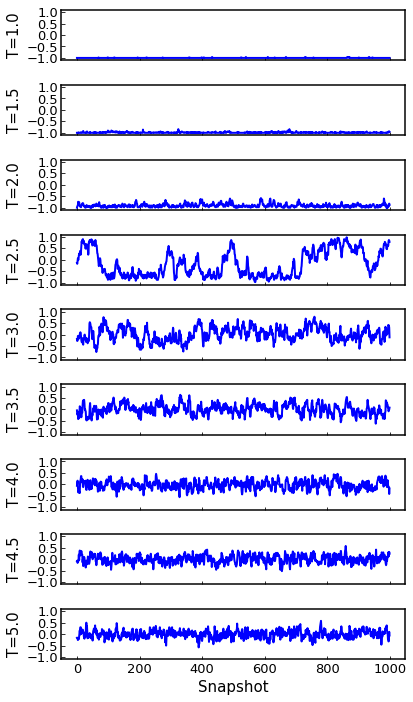

In [7]:
# simulation time vs. average magnetization
fig, ax = plot_traj(traj)
# plt.savefig(f'{result_dir}traj.svg', dpi=300, format='svg')

### 2.3 plot the average magnetization vs. temperature

In [8]:
def cal_mean_std(traj):
    '''calculate the average magnetization and corresponding SD.'''
    means = []
    stds = []
    for i, state in enumerate(traj):    
        tmp = np.sum(state, axis=0) / len(state)
        means.append(abs(np.mean(tmp)))
        stds.append(np.std(tmp))
    return means, stds

def plot_magnetization(means, stds, c='teal'):
    '''plot the average magnetization with errorbar.'''       
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.errorbar(range(len(means)), means, yerr=stds, fmt='-o', capsize=5,
                capthick=2, c=c)
    ax.tick_params(direction='in', labelsize=13)
    ax.grid(axis='y')
    ax.set_xticks(np.arange(9))
    ax.set_xticklabels(np.arange(1., 5.1, .5))
    ax.set_yticks(np.arange(-.6, 1.21, .3))
    ax.set_xlabel('Temperature', fontsize=15)
    ax.set_ylabel('Magnetization', fontsize=15)
    fig.tight_layout()
    return fig, ax

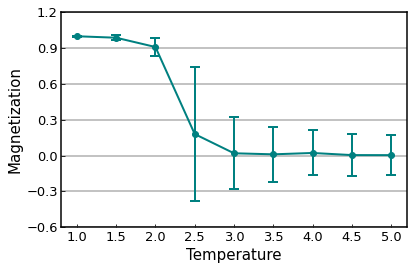

In [9]:
means, stds = cal_mean_std(traj)
fig, ax = plot_magnetization(means, stds)
# plt.savefig(f'{result_dir}mag.svg', dpi=300, format='svg')

## 3. apply GDNB algorithm to this simulated data

In [10]:
mydata = gdnb.GDNBData(traj)

Read the input data ...
The input data shape is: 9 x 100 x 1000
Number of windows: 9
Number of variables: 100
Number of samples: 1000

The next step is fitting data by .fit()


In [11]:
mydata.fit(pv_cut=0.05, pcc_cut=0.6, pbar_mode=tqdm)

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...



step 2: cluster selected variables ...



step 3: find the giant component (largest cluster) ...



fitting Done

--------------- Results Summary ---------------
number of variables in each largest cluster for each window:
[2, 2, 2, 48, 3, 2, 1, 1, 1]

average PCC of each largest cluster for each window:
[0.5000157548083776, 0.5668640432497587, 0.49781625685795367, 0.33687413021768964, 0.3932208695026635, 0.45436743370098165, 0, 0, 0]

average STD of each largest cluster for each window:
[0.177813114820562, 0.23482646189003797, 0.5202161868564111, 0.9885102339343402, 0.9997966343239545, 0.9996748949549203, 0, 0, 0]

composite index for each window:
[0.17781871764366403, 0.2662293552980446, 0.5179441497955528, 15.984169212859957, 1.1794227056241056, 0.9084394331119311, 0, 0, 0]


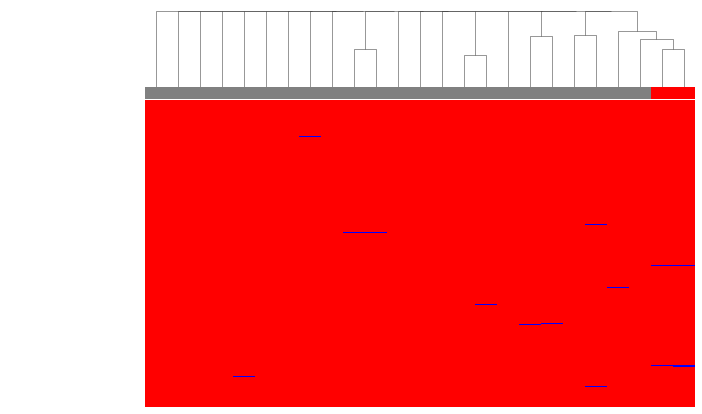

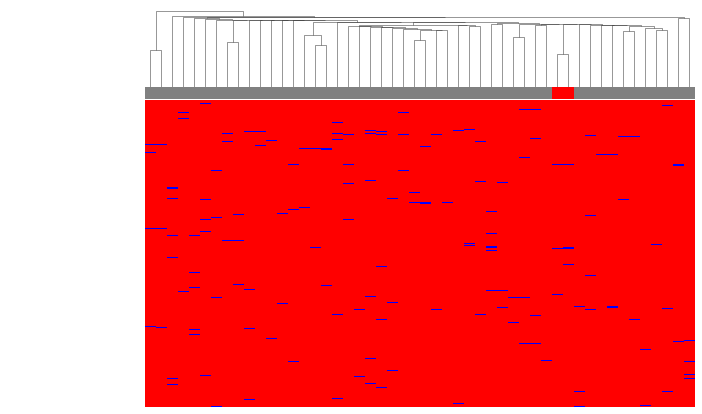

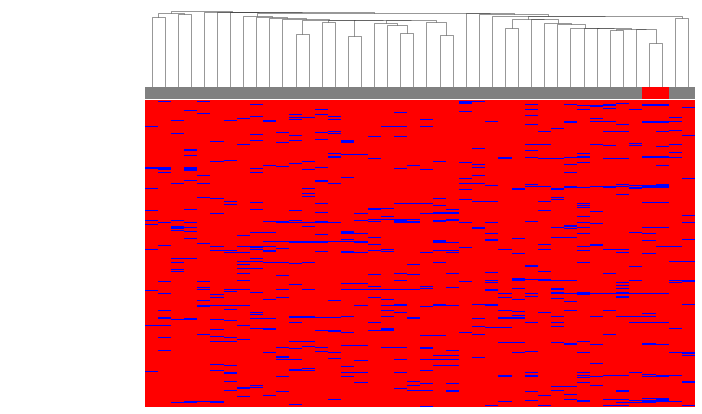

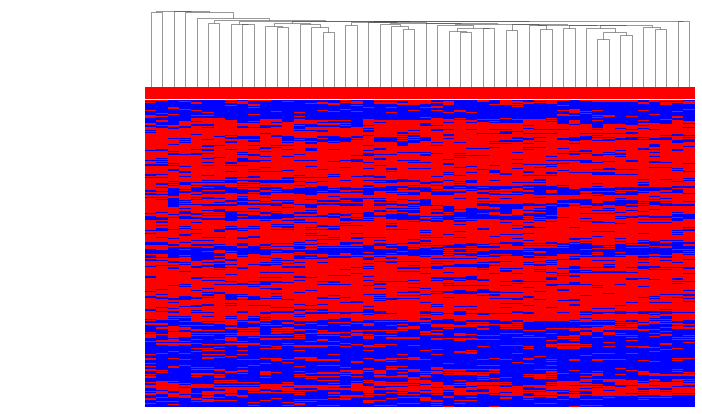

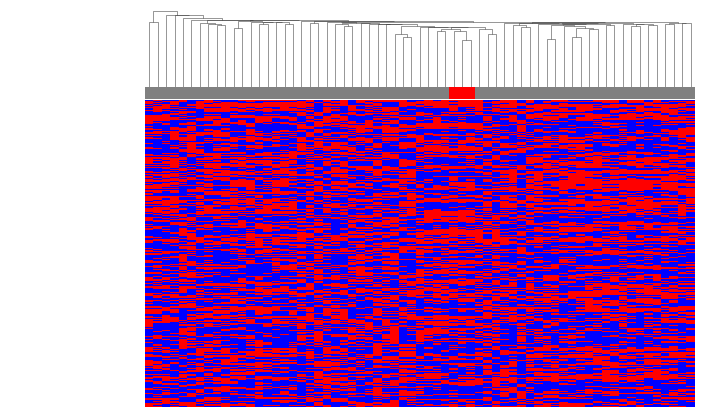

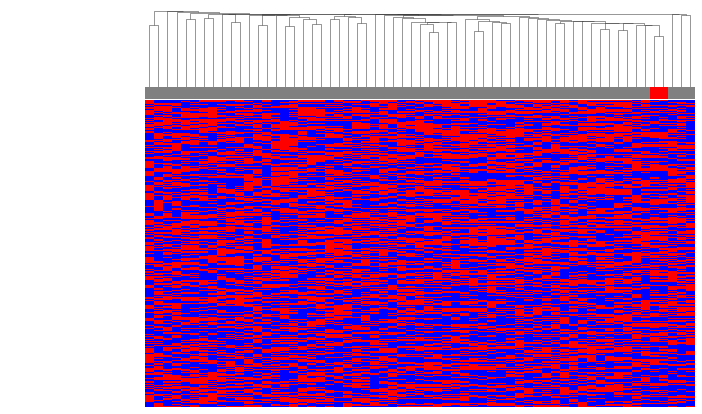

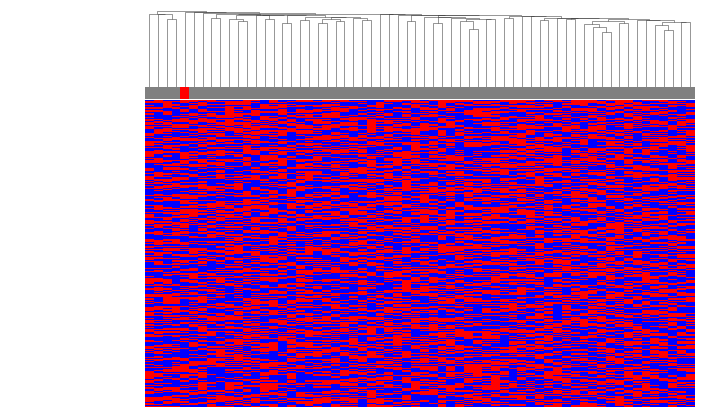

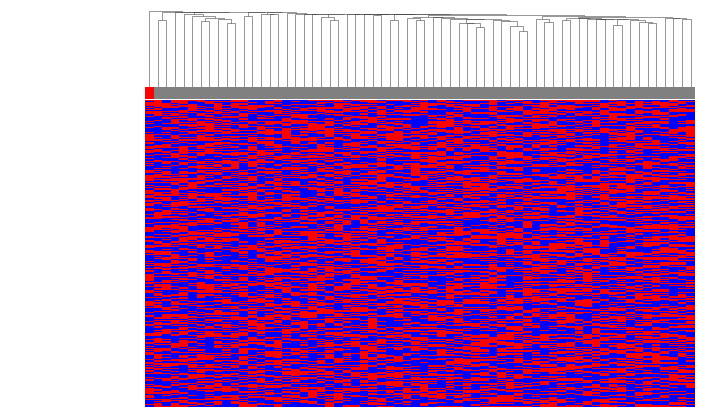

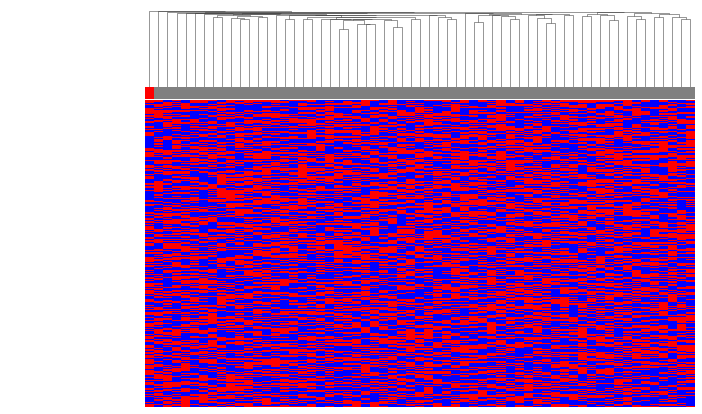

In [12]:
gs = mydata.plot_clusters(savefig=False, zscore=False, cbar_pos=None, cmap='bwr', fig_path=result_dir)

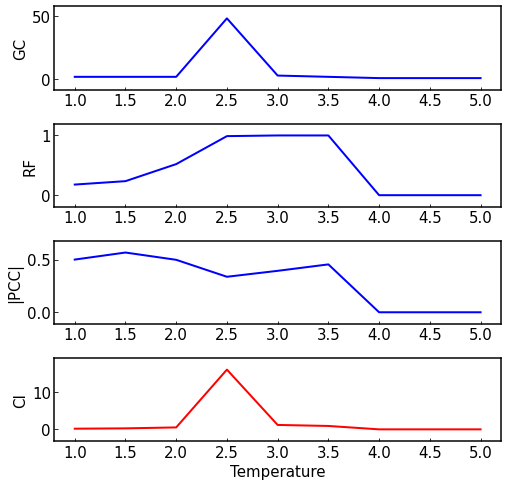

In [13]:
fig, ax = mydata.plot_index(xticks=range(9), xticklabels=np.arange(1, 5.1, 0.5), xlabel='Temperature')
# plt.savefig(f'{result_dir}four_index.svg', dpi=300, format='svg')

## 4. validate the GDNB results

In [14]:
def plot_ising_maps(data, lattice=10, s=100, ncol=3, figsize=(12, 12), 
                    c_list=['wheat','gray','red']):
    points = np.array([
        [j, i] for i in range(lattice) for j in range(lattice)])
    m = len(data.sele_index)
    Ts = np.arange(1, 5.1, .5)
    fig, ax = plt.subplots(int(m/ncol), ncol, figsize=figsize)
    ax=ax.flatten()

    for t in range(m):
        colors=[c_list[0]] * lattice ** 2
        for i in range(lattice ** 2):
            if i in data.sele_index[t][
                    np.where(
                        data.cls_index[t] == data.largest_cls_index[t])]:
                colors[i] = c_list[2]
            elif i in data.sele_index[t]:
                colors[i] = c_list[1]
            else:
                continue
        ax[t].scatter(points[:,0], points[:,1], color=colors, s=s)
        ax[t].set_title('T={:2.1f}'.format(Ts[t]), fontsize=18)
        ax[t].set_axis_off()        
    return fig, ax

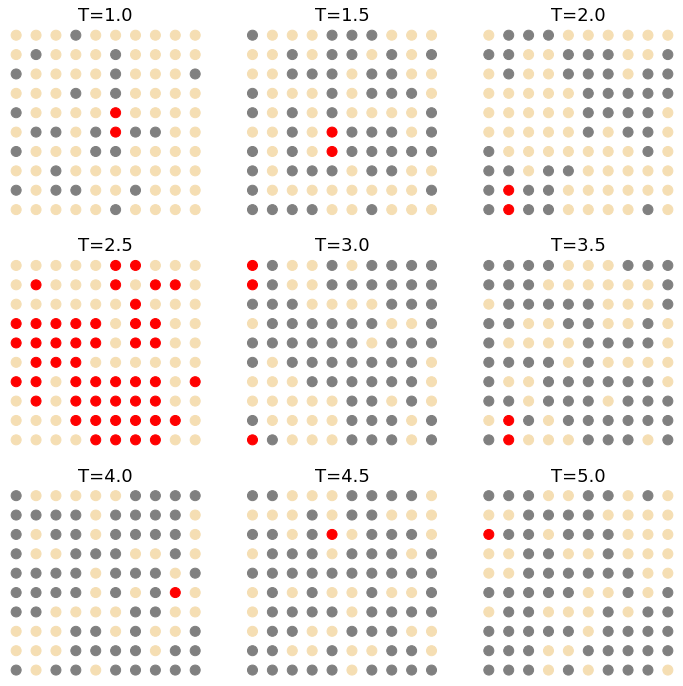

In [15]:
fig, ax = plot_ising_maps(mydata)
# plt.savefig(f'{result_dir}map.svg', dpi=300, format='svg')

## 5. Robust parameters in GDNB

In [16]:
cis = []
add_pcc_cuts = [0.50, 0.52, 0.54, 0.56, 0.58, 0.62, 0.64, 0.66, 0.68, 0.70]
for pcc_cut in add_pcc_cuts:
    mydata.fit(pv_cut=0.05, pcc_cut=pcc_cut, progress_bar=False, print_summary=False)
    cis.append(mydata.composite_index)

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting da

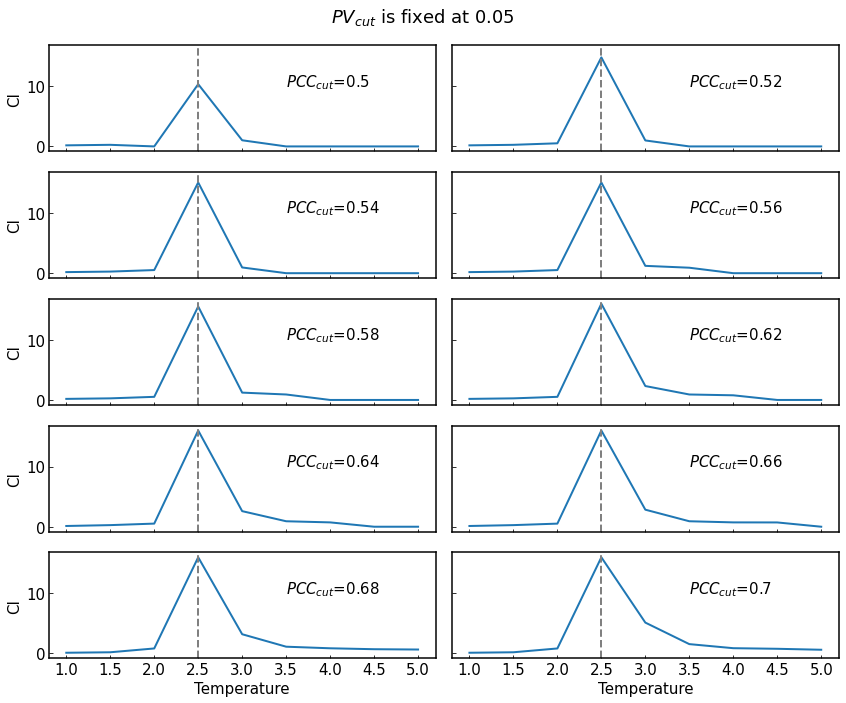

In [17]:
fig, ax = plt.subplots(5, 2, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()
label1 = '$PV_{cut}$'
label2 = '$PCC_{cut}$'
for i, ci in enumerate(cis):
    ax[i].plot(ci)
    ax[i].set_xticks(range(9))
    ax[i].set_xticklabels(np.arange(1, 5.1, .5))
    ax[i].text(5, 10, f'{label2}={add_pcc_cuts[i]}')
    if i % 2 == 0:
        ax[i].set_ylabel('CI')
    if i > 7:
        ax[i].set_xlabel('Temperature')
    ax[i].axvline(x=3, ls='--', c='grey')
plt.suptitle('$PV_{cut}$ is fixed at 0.05')
plt.tight_layout()
# plt.savefig(f'{result_dir}pv_fix.svg', dpi=300, format='svg')

In [18]:
cis = []
add_pv_cuts = [0.1, 0.01, 0.005, 0.001]
for pv_cut in add_pv_cuts:
    mydata.fit(pv_cut=pv_cut, pcc_cut=0.6, progress_bar=False, print_summary=False)
    cis.append(mydata.composite_index)

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...
step 2: cluster selected variables ...
step 3: find the giant component (largest cluster) ...
fitting Done



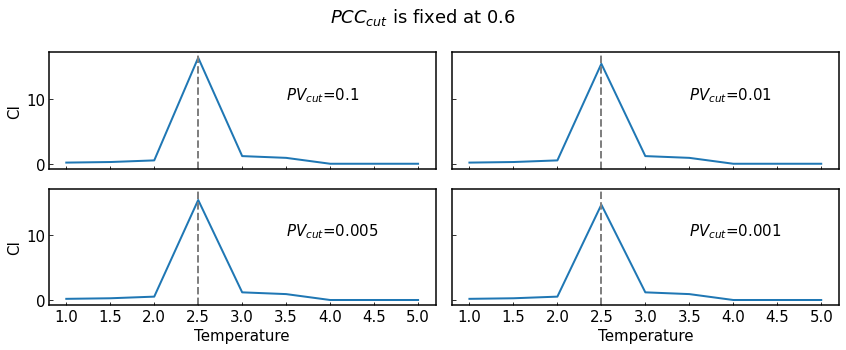

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey=True)
ax = ax.flatten()
label1 = '$PV_{cut}$'
label2 = '$PCC_{cut}$'
for i, ci in enumerate(cis):
    ax[i].plot(ci)
    ax[i].set_xticks(range(9))
    ax[i].set_xticklabels(np.arange(1, 5.1, .5))
    ax[i].text(5, 10, f'{label1}={add_pv_cuts[i]}')
    if i % 2 == 0:
        ax[i].set_ylabel('CI')
    if i > 1:
        ax[i].set_xlabel('Temperature')
    ax[i].axvline(x=3, ls='--', c='grey')
plt.suptitle('$PCC_{cut}$ is fixed at 0.6')
plt.tight_layout()
# plt.savefig(f'{result_dir}pcc_fix.svg', dpi=300, format='svg')

## 6. Try the GDNB method on bigger Ising system

In [20]:
lattice = 32
sim_steps = 500000
seed = 1
result_dir = f'results/ising/lat{lattice}_sim{seed}/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
    
traj = gdnb.load_ising(lattice=lattice, sim_steps=sim_steps, seed=seed, pbar_mode=tqdm)

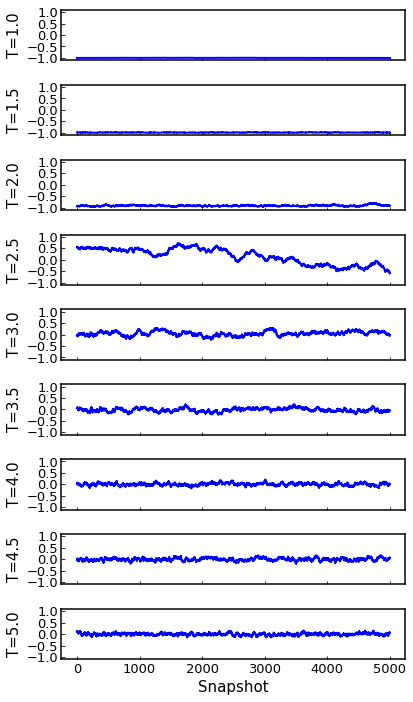

In [21]:
fig, ax = plot_traj(traj)
# plt.savefig(f'{result_dir}traj.svg', dpi=300, format='svg')

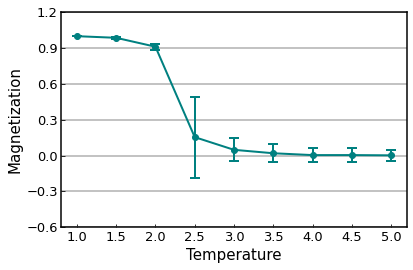

In [22]:
means, stds = cal_mean_std(traj)
fig, ax = plot_magnetization(means, stds)
# plt.savefig(f'{result_dir}mag.svg', dpi=300, format='svg')

In [23]:
mydata = gdnb.GDNBData(traj)

Read the input data ...
The input data shape is: 9 x 1024 x 5000
Number of windows: 9
Number of variables: 1024
Number of samples: 5000

The next step is fitting data by .fit()


In [25]:
mydata.fit(pv_cut=0.05, pcc_cut=0.6, pbar_mode=tqdm)

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...



step 2: cluster selected variables ...



step 3: find the giant component (largest cluster) ...



fitting Done

--------------- Results Summary ---------------
number of variables in each largest cluster for each window:
[5, 17, 23, 620, 10, 3, 2, 1, 1]

average PCC of each largest cluster for each window:
[0.4197435740170766, 0.18703143468348163, 0.2377910466003459, 0.15356153906171757, 0.23414500919861334, 0.3605813600753724, 0.40844259753062223, 0, 0]

average STD of each largest cluster for each window:
[0.08262139143726506, 0.2218562363741423, 0.5472243836252361, 0.9943727042699082, 0.9984670435035007, 0.9994205637606148, 0.9996759433759246, 0, 0]

composite index for each window:
[0.17339899066070763, 0.7053995331030688, 2.9928763548719033, 94.67238977856253, 2.3378607508563944, 1.0811172785042937, 0.8166204780026757, 0, 0]


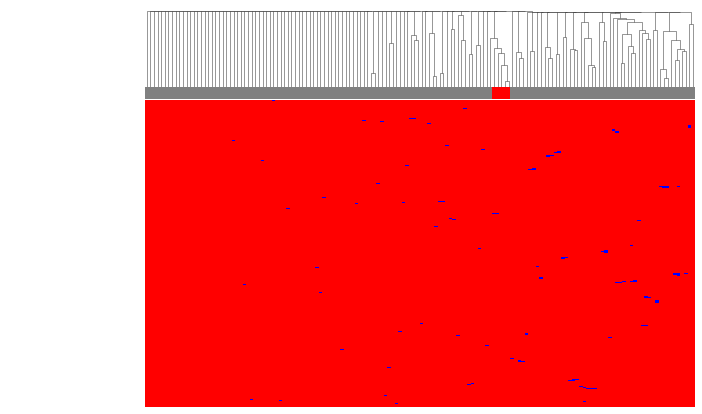

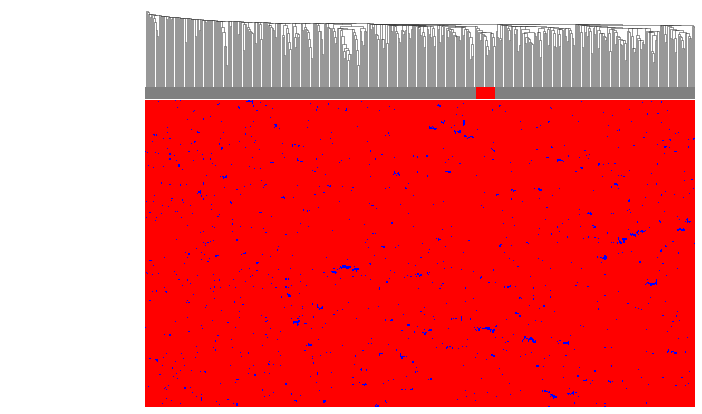

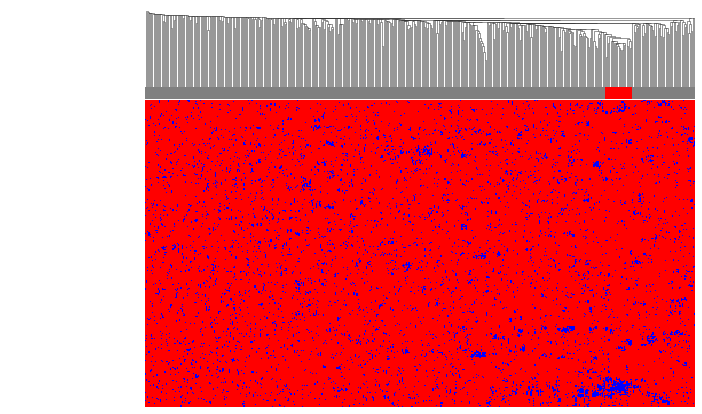

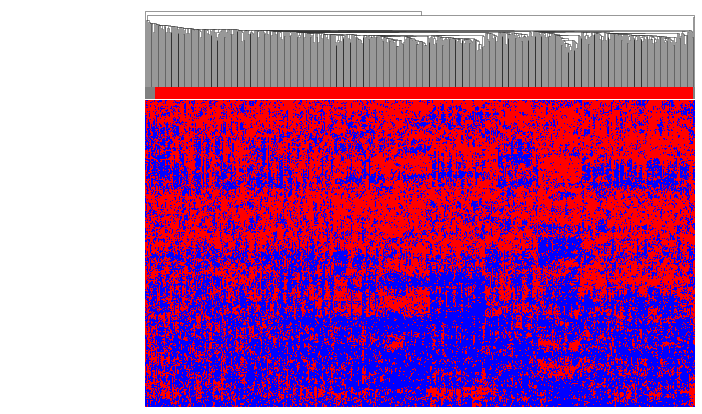

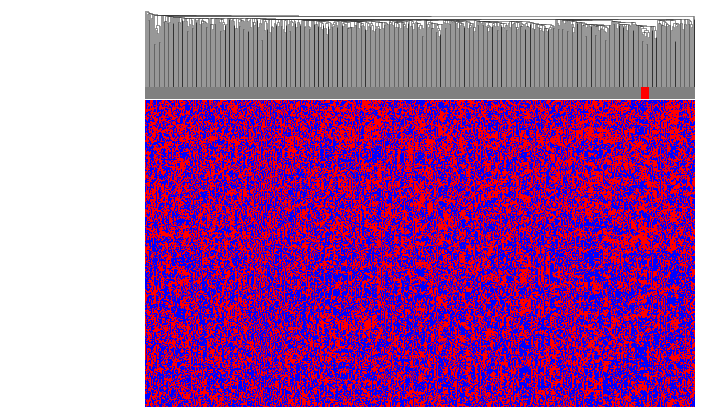

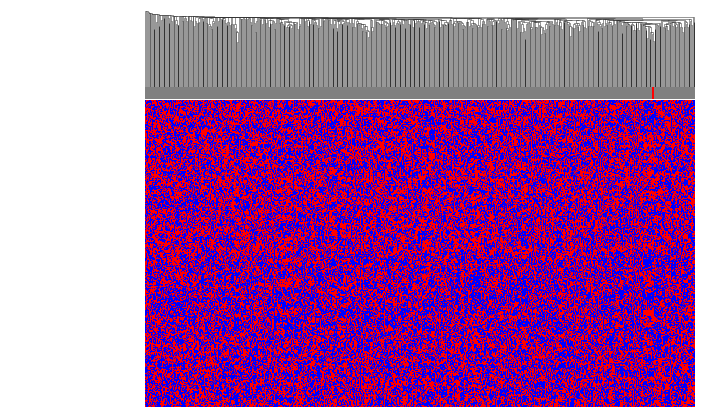

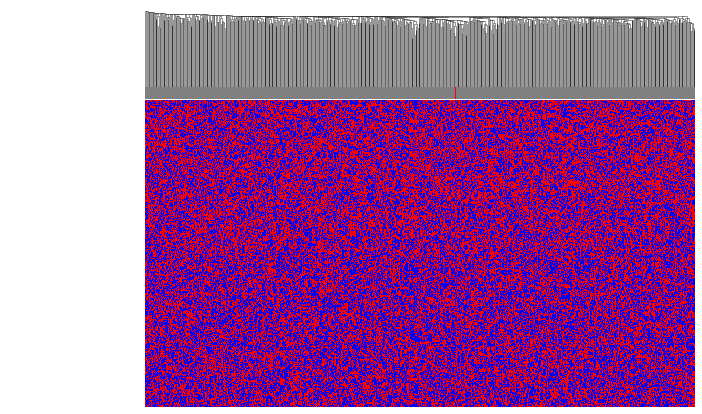

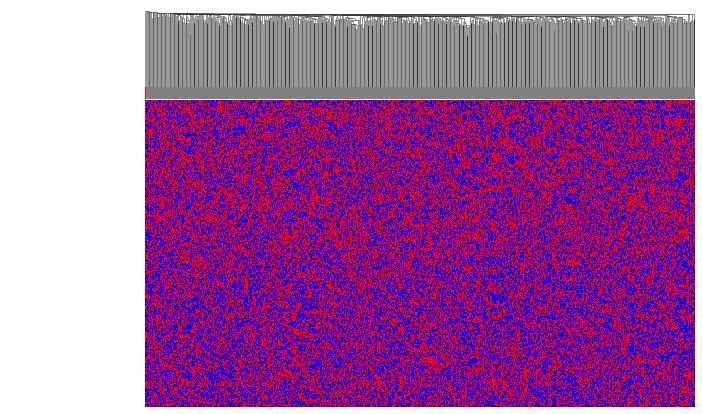

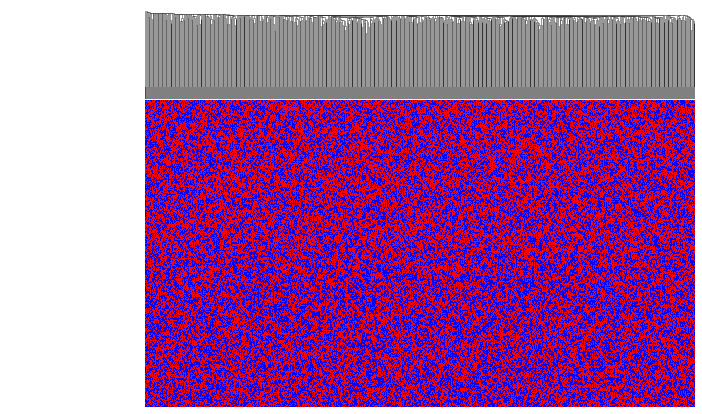

In [26]:
gs = mydata.plot_clusters(savefig=False, zscore=False, cbar_pos=None, cmap='bwr', fig_path=result_dir)

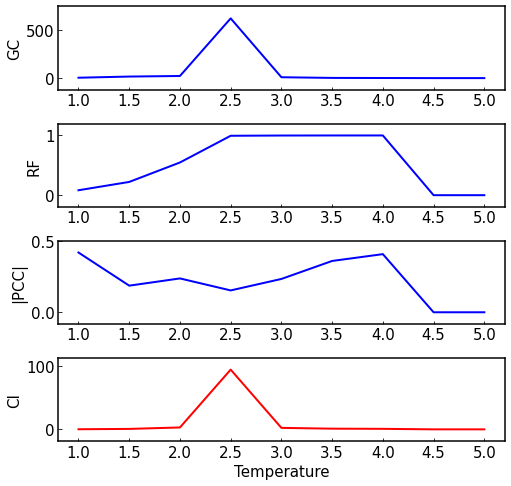

In [27]:
fig, ax = mydata.plot_index(xticks=range(9), xticklabels=np.arange(1, 5.1, 0.5), xlabel='Temperature')
# plt.savefig(f'{result_dir}four_index.svg', dpi=300, format='svg')

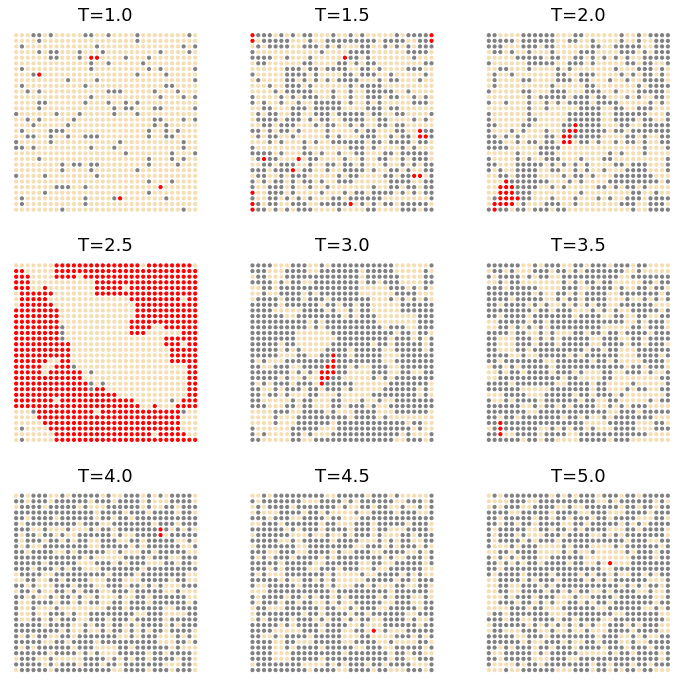

In [28]:
fig, ax = plot_ising_maps(mydata, lattice=32, s=10)
# plt.savefig(f'{result_dir}map.svg', dpi=300, format='svg')